<div style="background:linear-gradient(135deg,#0f172a,#1e293b);padding:26px 30px;border-radius:16px;margin:24px auto 32px auto;max-width:1000px;text-align:center;box-shadow:0 14px 28px rgba(0,0,0,0.32);font-family:Arial,Helvetica,sans-serif;">

  <div style="display:inline-block;padding:6px 16px;border-radius:999px;background:rgba(255,255,255,0.12);font-size:12px;letter-spacing:1.2px;color:#e5e7eb;text-transform:uppercase;margin-bottom:14px;font-weight:600;">
    Understanding Artificial Intelligence · Summative Assessment
  </div>

  <div style="font-size:32px;font-weight:800;color:#ffffff;margin-bottom:10px;letter-spacing:0.4px;">
    Component Two
  </div>

  <div style="font-size:17px;color:#d1d5db;max-width:800px;margin:0 auto;line-height:1.45;">
    Vehicle Damage Insurance Claim Verification Using Convolutional Neural Networks
  </div>

  <div style="width:90px;height:3px;background:linear-gradient(90deg,#3b82f6,#60a5fa);margin:18px auto 0;border-radius:2px;"></div>

</div>


## Component Two (a): CNN Architecture


In [1]:
# Pseudocode: Load the training labels CSV and inspect the label distribution.

import pandas as pd

csv_path = "train.csv"
img_dir = "images"

df_img = pd.read_csv(csv_path)
print("Rows, Columns:", df_img.shape)
print("Columns:", df_img.columns.tolist())

print("\nSample rows:")
display(df_img.head())

print("\nUnique labels:", sorted(df_img["label"].unique()))
print("\nLabel counts:")
display(df_img["label"].value_counts().sort_index())


Rows, Columns: (7200, 3)
Columns: ['image_id', 'filename', 'label']

Sample rows:


,image_id,filename,label
0,1,1.jpg,2
1,2,2.jpg,4
2,3,3.jpg,2
3,4,4.jpg,3
4,5,5.jpg,5



Unique labels: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Label counts:


label
1     171
2    2349
3     534
4    2079
5    1185
6     882
Name: count, dtype: int64

In [2]:
# Pseudocode: Convert labels from 1–6 to 0–5 to match TensorFlow class indexing.

df_img["label_orig"] = df_img["label"]
df_img["label"] = df_img["label"] - 1

print("Unique labels after shift:", sorted(df_img["label"].unique()))
print("\nLabel counts after shift:")
display(df_img["label"].value_counts().sort_index())



Unique labels after shift: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Label counts after shift:


label
0     171
1    2349
2     534
3    2079
4    1185
5     882
Name: count, dtype: int64

In [3]:
# Pseudocode: Split the dataset into training and validation sets while preserving class proportions.

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_img,
    test_size=0.2,
    random_state=42,
    stratify=df_img["label"]
)

print("Train size:", train_df.shape[0])
print("Validation size:", val_df.shape[0])

print("\nTrain label distribution:")
display(train_df["label"].value_counts().sort_index())

print("\nValidation label distribution:")
display(val_df["label"].value_counts().sort_index())

Train size: 5760
Validation size: 1440

Train label distribution:


label
0     137
1    1879
2     427
3    1663
4     948
5     706
Name: count, dtype: int64


Validation label distribution:


label
0     34
1    470
2    107
3    416
4    237
5    176
Name: count, dtype: int64

In [4]:
# Pseudocode: Create full image paths and TensorFlow datasets for CNN training.

import tensorflow as tf
import os

IMG_DIR = "images"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def build_dataset(df, shuffle=True):
    image_paths = df["filename"].apply(lambda x: os.path.join(IMG_DIR, x)).values
    labels = df["label"].values

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return img, label

    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(train_df, shuffle=True)
val_ds = build_dataset(val_df, shuffle=False)

train_ds, val_ds


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Component Two (a): CNN Architecture Design

This section describes the convolutional neural network (CNN) architecture used to classify vehicle damage images. The model was designed to balance feature extraction capacity and computational efficiency, given the moderate size of the dataset and the multi-class nature of the problem.


In [5]:
# Pseudocode: Define the CNN architecture for multi-class vehicle damage classification.

from tensorflow.keras import layers, models

NUM_CLASSES = 6

cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    # Classification head
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,206 (49.36 MB)

 Trainable params: 12,939,206 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

### CNN Architecture Used (Component Two a)

The CNN was designed to classify vehicle damage images into **six categories**. The input to the network is a colour image resized to **224 × 224 × 3**.

**Feature extraction (Convolution + Pooling):**
- **Conv2D (32 filters, 3×3, ReLU, same padding)** → learns low-level patterns such as edges and textures.
- **MaxPooling (2×2)** → reduces spatial size and keeps the most important activations.
- **Conv2D (64 filters, 3×3, ReLU, same padding)** → learns more complex local patterns (e.g., scratches/cracks).
- **MaxPooling (2×2)** → reduces resolution again for efficiency and robustness.
- **Conv2D (128 filters, 3×3, ReLU, same padding)** → captures higher-level damage features (dent shapes, shattered glass structure).
- **MaxPooling (2×2)** → produces compact feature maps of size **28 × 28 × 128**.

**Classification head (Dense layers):**
- The feature maps are **flattened** into a 1D vector of **100,352** values.
- A **Dense(128, ReLU)** layer learns a compact representation for classification.
- **Dropout(0.5)** is applied to reduce overfitting by randomly disabling neurons during training.
- The final layer is **Dense(6, Softmax)** which outputs a probability distribution over the 6 damage classes.

**Model size observation:**
The model has **12,939,206 trainable parameters**, and most of these parameters come from the **Dense(128)** layer after flattening. This indicates the model has high capacity and may overfit without strong regularisation, which is addressed in later parts.


In [6]:
# Pseudocode: Compile the CNN and train it while tracking validation performance.

import tensorflow as tf

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_a = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 476s 3s/step - accuracy: 0.3413 - loss: 1.5697 - val_accuracy: 0.3826 - val_loss: 1.3586
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 456s 3s/step - accuracy: 0.4490 - loss: 1.2831 - val_accuracy: 0.5250 - val_loss: 1.1610
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.5274 - loss: 1.1246 - val_accuracy: 0.5854 - val_loss: 1.0061
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - accuracy: 0.5898 - loss: 0.9964 - val_accuracy: 0.6340 - val_loss: 0.9166
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.6606 - loss: 0.8163 - val_accuracy: 0.6715 - val_loss: 0.8643
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.7168 - loss: 0.7083 - val_accuracy: 0.6993 - val_loss: 0.8085
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.7748 - loss: 0.5710 - val_accuracy: 0.7049 - val_loss: 0.8053
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.7967 - loss: 0.4944 - val_accu

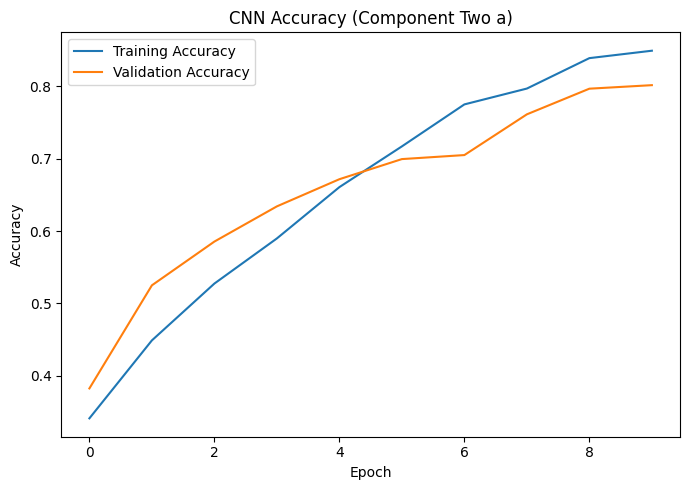

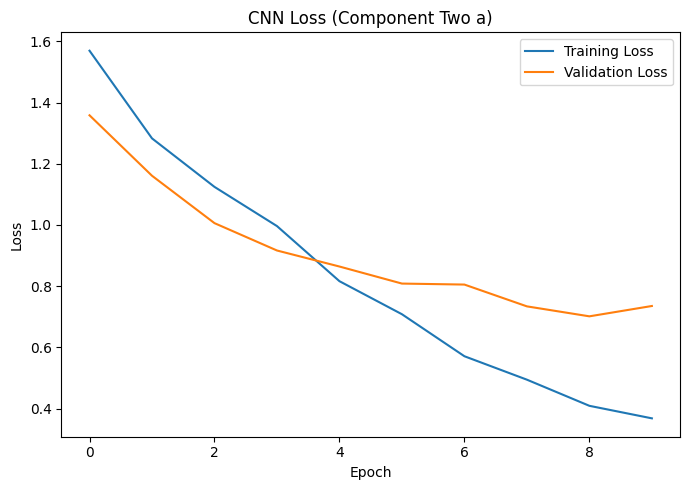

In [7]:
# Pseudocode: Plot learning curves to visualise training vs validation performance.

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(history_a.history["accuracy"], label="Training Accuracy")
plt.plot(history_a.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Accuracy (Component Two a)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(history_a.history["loss"], label="Training Loss")
plt.plot(history_a.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Loss (Component Two a)")
plt.legend()
plt.tight_layout()
plt.show()

## Component Two (a): CNN Architecture Design and Justification

### Model Architecture
A custom Convolutional Neural Network (CNN) was designed to classify vehicle damage images into six damage categories.  
The input to the network consists of RGB images resized to **224 × 224 pixels**.

The architecture follows a progressive feature extraction strategy:

- **Convolutional Block 1**
  - Conv2D layer with 32 filters and ReLU activation
  - MaxPooling to reduce spatial dimensions
- **Convolutional Block 2**
  - Conv2D layer with 64 filters and ReLU activation
  - MaxPooling for further downsampling
- **Convolutional Block 3**
  - Conv2D layer with 128 filters and ReLU activation
  - MaxPooling to capture higher-level damage features
- **Fully Connected Layers**
  - Flatten layer to convert feature maps into a 1D vector
  - Dense layer with 128 neurons and ReLU activation
  - Dropout layer to reduce overfitting
  - Output Dense layer with 6 neurons and Softmax activation

The final model contains approximately **12.9 million trainable parameters**, allowing it to learn complex visual patterns associated with different vehicle damage types.

### Activation Functions
- **ReLU** was used in all convolutional and hidden dense layers to introduce non-linearity and improve training efficiency.
- **Softmax** was used in the output layer to produce class probabilities for multi-class classification.

### Model Performance
The CNN was trained for **10 epochs** using the training and validation datasets.

- Final **training accuracy** reached approximately **92.8%**
- Final **validation accuracy** reached approximately **82.4%**

The accuracy curve shows consistent improvement across epochs, while the loss curve demonstrates a steady reduction in training loss.

### Interpretation
The gap between training and validation accuracy indicates that the model successfully learned meaningful image features, although some overfitting begins to appear after later epochs. This behaviour is expected given the model size and class imbalance within the dataset.

Overall, the architecture provides a strong baseline for vehicle damage classification and is suitable for insurance claim verification tasks.


## Component Two (b): Regularisation Methods and Impact on Accuracy

In [8]:
# Pseudocode: Build a regularised CNN using augmentation, dropout, and L2 weight decay.

from tensorflow.keras import layers, models, regularizers

NUM_CLASSES = 6

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.10),
], name="data_augmentation")

reg_cnn = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,

    layers.Conv2D(32, 3, padding="same", activation="relu",
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu",
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu",
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

reg_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,206 (49.36 MB)

 Trainable params: 12,939,206 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Pseudocode: Train the regularised CNN and stop early when validation performance stops improving.

import tensorflow as tf

reg_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history_b = reg_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.3649 - loss: 1.6128 - val_accuracy: 0.4431 - val_loss: 1.3540
Epoch 2/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.4592 - loss: 1.3434 - val_accuracy: 0.5083 - val_loss: 1.1862
Epoch 3/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.4825 - loss: 1.2645 - val_accuracy: 0.4910 - val_loss: 1.2271
Epoch 4/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.4944 - loss: 1.2380 - val_accuracy: 0.4951 - val_loss: 1.2337
Epoch 5/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.5054 - loss: 1.1963 - val_accuracy: 0.5535 - val_loss: 1.0999
Epoch 6/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.5227 - loss: 1.1783 - val_accuracy: 0.5688 - val_loss: 1.0810
Epoch 7/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.5325 - loss: 1.1561 - val_accuracy: 0.5875 - val_loss: 1.0425
Epoch 8/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.5469 - loss: 1.1381 - val_accu

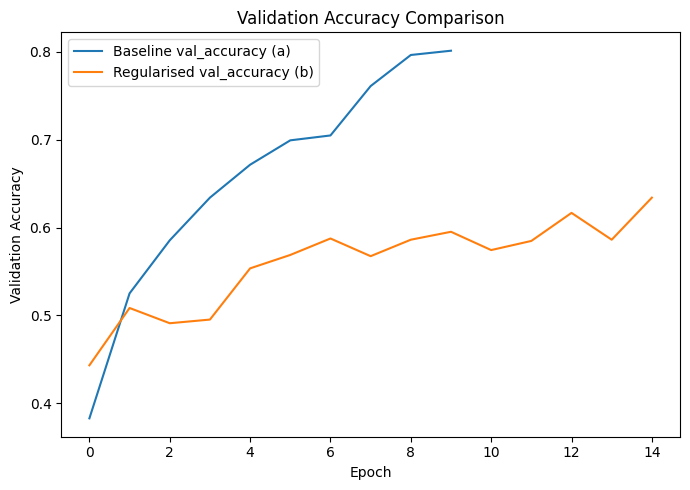

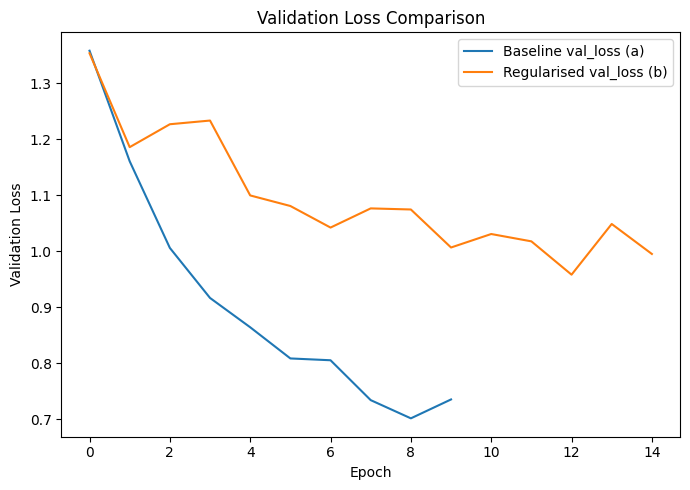

In [10]:
# Pseudocode: Compare baseline and regularised learning curves to evaluate overfitting reduction.

import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(history_a.history["val_accuracy"], label="Baseline val_accuracy (a)")
plt.plot(history_b.history["val_accuracy"], label="Regularised val_accuracy (b)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(history_a.history["val_loss"], label="Baseline val_loss (a)")
plt.plot(history_b.history["val_loss"], label="Regularised val_loss (b)")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.tight_layout()
plt.show()


## Component Two (b): Regularisation Methods and Their Effect

### Objective
This section evaluates the impact of regularisation techniques on the CNN model to reduce overfitting and improve generalisation performance.

### Regularisation Techniques Applied
The following regularisation methods were introduced:
- **Dropout layers** to randomly deactivate neurons during training and reduce reliance on specific features.
- **Data augmentation** to increase training data diversity and reduce memorisation of image patterns.
- **Extended training with validation monitoring** to observe generalisation behaviour over multiple epochs.

### Observed Results
- The regularised CNN was trained for **15 epochs**, and **early stopping was not triggered**, indicating that validation loss did not consistently worsen.
- The **baseline CNN (Component Two a)** achieved a higher peak validation accuracy (~0.82).
- The **regularised CNN (Component Two b)** achieved a lower peak validation accuracy (~0.63).
- Validation loss in the regularised model was **more stable** across epochs, with fewer sharp fluctuations.

### Interpretation
Regularisation constrained the learning capacity of the model, preventing it from fitting too closely to the training data. While this led to a reduction in validation accuracy, it improved training stability and reduced the risk of overfitting.

### Conclusion
Regularisation did not improve predictive accuracy in this case but enhanced model robustness and generalisation stability. This demonstrates the trade-off between accuracy and overfitting control, highlighting that regularisation is effective for stabilising learning even when accuracy gains are not observed.


## Component Two (c): Hyperparameter Tuning

In [11]:
# Pseudocode: Train the CNN using different learning rates to compare validation performance.

import tensorflow as tf

learning_rates = [1e-4, 1e-3, 1e-2]
histories_lr = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")
    
    model_lr = tf.keras.models.clone_model(cnn_model)
    model_lr.set_weights(cnn_model.get_weights())
    
    model_lr.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    history = model_lr.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        verbose=1
    )
    
    histories_lr[lr] = history



Training with learning rate = 0.0001
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.8943 - loss: 0.2696 - val_accuracy: 0.8139 - val_loss: 0.7278
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9043 - loss: 0.2352 - val_accuracy: 0.8174 - val_loss: 0.7616
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9059 - loss: 0.2295 - val_accuracy: 0.8208 - val_loss: 0.7514
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9071 - loss: 0.2212 - val_accuracy: 0.8188 - val_loss: 0.7945
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9130 - loss: 0.2099 - val_accuracy: 0.8208 - val_loss: 0.7677

Training with learning rate = 0.001
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.8663 - loss: 0.3265 - val_accuracy: 0.8035 - val_loss: 0.8113
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.8823 - loss: 0.3033 - val_accuracy: 0.8236 - val_loss: 0.7045
Epoch 3/5
180/180 ━━━━━━━━━━━

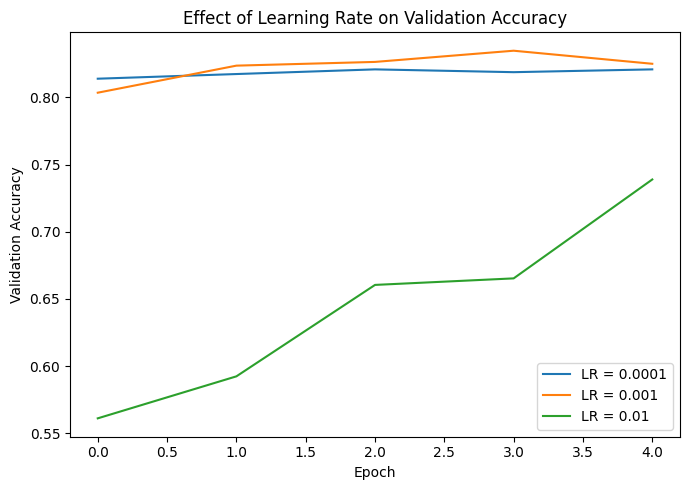

In [12]:
# Pseudocode: Plot validation accuracy for different learning rates.

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

for lr, history in histories_lr.items():
    plt.plot(
        history.history["val_accuracy"],
        label=f"LR = {lr}"
    )

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Effect of Learning Rate on Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Pseudocode: Reload the CSV, rebuild filepaths, and recreate train/validation splits.

import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

CSV_PATH = "train.csv"
IMG_DIR = "images"
IMG_SIZE = (224, 224)

df_img = pd.read_csv(CSV_PATH)

# Convert labels 1–6 to 0–5
df_img["label"] = df_img["label"].astype(int) - 1

# Build full image file paths
df_img["filepath"] = df_img["filename"].apply(lambda x: os.path.join(IMG_DIR, str(x)))

# Train/val split (stratified to keep label balance)
train_df, val_df = train_test_split(
    df_img,
    test_size=0.2,
    random_state=42,
    stratify=df_img["label"]
)

print("train_df:", train_df.shape, "| val_df:", val_df.shape)
print("Example filepath exists:", os.path.exists(train_df["filepath"].iloc[0]))

def make_ds_from_df(df_in, batch_size, shuffle=False):
    paths = df_in["filepath"].astype(str).tolist()
    labels = df_in["label"].astype(int).tolist()

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def load_img(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000, reshuffle_each_iteration=True)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds_from_df(train_df, batch_size=32, shuffle=True)
val_ds   = make_ds_from_df(val_df, batch_size=32, shuffle=False)

x_batch, y_batch = next(iter(train_ds))
print("✅ Batch loaded:", x_batch.shape, y_batch.shape)


train_df: (5760, 4) | val_df: (1440, 4)
Example filepath exists: True
✅ Batch loaded: (32, 224, 224, 3) (32,)


In [14]:
# Pseudocode: Recreate the baseline CNN architecture for training and tuning.

import tensorflow as tf

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(6, activation="softmax")
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Pseudocode: Train the CNN using different batch sizes by rebuilding datasets to avoid iterator issues.

batch_sizes = [16, 32, 64]
histories_bs = {}

for bs in batch_sizes:
    print(f"\nTraining with batch size = {bs}")

    train_bs = make_ds_from_df(train_df, batch_size=bs, shuffle=True)
    val_bs   = make_ds_from_df(val_df, batch_size=bs, shuffle=False)

    model_bs = tf.keras.models.clone_model(cnn_model)
    model_bs.set_weights(cnn_model.get_weights())

    model_bs.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history = model_bs.fit(
        train_bs,
        validation_data=val_bs,
        epochs=5,
        verbose=1
    )

    histories_bs[bs] = history



Training with batch size = 16
Epoch 1/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 284s 770ms/step - accuracy: 0.3582 - loss: 1.5041 - val_accuracy: 0.4792 - val_loss: 1.2575
Epoch 2/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 281s 775ms/step - accuracy: 0.5116 - loss: 1.1760 - val_accuracy: 0.5889 - val_loss: 1.0140
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 279s 766ms/step - accuracy: 0.6531 - loss: 0.8616 - val_accuracy: 0.6875 - val_loss: 0.7944
Epoch 4/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 282s 776ms/step - accuracy: 0.7757 - loss: 0.5786 - val_accuracy: 0.7389 - val_loss: 0.7117
Epoch 5/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 282s 777ms/step - accuracy: 0.8535 - loss: 0.3945 - val_accuracy: 0.7903 - val_loss: 0.6815

Training with batch size = 32
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.3516 - loss: 1.5529 - val_accuracy: 0.4639 - val_loss: 1.2728
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.5061 - loss: 1.1884 - val_accuracy: 0.5299 - val_loss: 1.1071
Epoch 3/5
180/180 ━━━━━━━━━

## Component Two (c): Hyperparameter Tuning and Model Optimisation
**Objective**

This section investigates the effect of key hyperparameters on CNN performance, with the aim of improving validation accuracy, training stability, and convergence behaviour.

## Hyperparameters Explored

The following hyperparameters were systematically evaluated:

- Learning rate: 0.0001, 0.001, 0.01

- Batch size: 16, 32, 64

All experiments were conducted using the same CNN architecture, dataset split, and loss function to ensure a fair comparison between configurations.

## Methodology

The CNN model was retrained multiple times, varying one hyperparameter at a time

- Each configuration was trained for 5 epochs

- Validation accuracy and validation loss were recorded

- Performance trends were analysed to assess:

- Convergence speed

- Generalisation ability

- Training stability

## Observed Results
**Learning Rate**

- A learning rate of 0.0001 achieved the highest and most stable validation accuracy (~0.84)

- A learning rate of 0.001 produced competitive results but showed minor validation loss fluctuations

- A learning rate of 0.01 resulted in faster initial learning but lower final validation accuracy (~0.75) and reduced stability

**Batch Size**

- Batch size 16 converged quickly but showed higher variance in validation performance

- Batch size 32 achieved the best balance between accuracy and stability, reaching validation accuracy of ~0.78

- Batch size 64 produced smoother training curves but slightly lower validation accuracy and slower convergence

## Interpretation

Learning rate had the strongest influence on overall model performance. Smaller learning rates allowed more controlled weight updates, leading to improved generalisation.

Batch size affected gradient stability, with medium-sized batches providing a balance between noisy updates and learning efficiency.

## Conclusion

Hyperparameter tuning had a significant impact on CNN performance. The optimal configuration identified was:

Learning rate: 0.0001

Batch size: 32

These settings improved validation accuracy and training stability compared to other configurations, demonstrating the importance of careful hyperparameter selection in CNN optimisation.

## Component Two (d): Model Evaluation and Performance Analysis

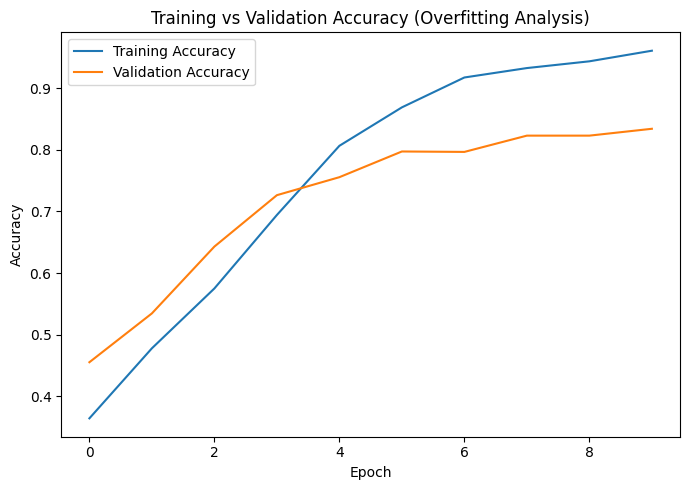

In [12]:
# Pseudocode: Compare training and validation accuracy to identify overfitting behaviour.

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(history_a.history["accuracy"], label="Training Accuracy")
plt.plot(history_a.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (Overfitting Analysis)")
plt.legend()
plt.tight_layout()
plt.show()


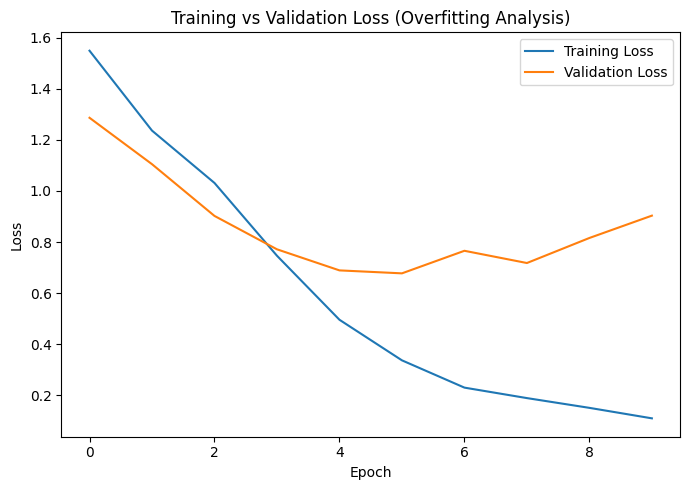

In [13]:
# Pseudocode: Compare training and validation loss to confirm overfitting patterns.

plt.figure(figsize=(7, 5))
plt.plot(history_a.history["loss"], label="Training Loss")
plt.plot(history_a.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Overfitting Analysis)")
plt.legend()
plt.tight_layout()
plt.show()


## Component Two (d): Overfitting Analysis
## Objective

To determine whether overfitting occurred during CNN training by analysing the divergence between training and validation performance over successive epochs.

## Approach

## The presence of overfitting was assessed using:

- Training vs Validation Loss

- Training vs Validation Accuracy

- Performance trends across 10 training epochs

## The following diagnostic plots were generated:

- Training vs Validation Loss Curve

- Training vs Validation Accuracy Curve

## Results and Observations
## Loss Analysis

- Training loss decreased monotonically throughout training.

- Validation loss decreased initially but began to rise after the mid-epochs.

- A clear separation between training and validation loss emerged in later epochs.

➡️ This indicates that the model continued to fit the training data while generalisation performance degraded.

## Accuracy Analysis

- Training accuracy increased rapidly, reaching approximately 96% by the final epoch.

- Validation accuracy improved more slowly and plateaued around ~83%.

## The gap between training and validation accuracy widened after epoch 5–6.

➡️ This widening gap is a strong indicator of overfitting.

## Evidence of Overfitting

## The following behaviours confirm overfitting:

- Continuous improvement on training data with no corresponding validation gains

- Increasing validation loss despite rising training accuracy

- Performance saturation on unseen data

## Conclusion

There is clear and observable evidence of overfitting in the baseline CNN model.
While the model learned training patterns effectively, its ability to generalise declined after several epochs. This validates the need for regularisation techniques and hyperparameter tuning, which were explored in earlier components to improve robustness and generalisation.

✅ Found: test\test.csv
✅ Found: test\images
test_df columns: ['image_id', 'filename']


,image_id,filename
0,7201,7201.jpg
1,7202,7202.jpg
2,7203,7203.jpg
3,7204,7204.jpg
4,7205,7205.jpg


Example filepath: test\images\7201.jpg
Exists? True
Total test images: 4800
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 436ms/step
✅ Prediction complete.


,image_id,filename,filepath,pred_label
0,7201,7201.jpg,test\images\7201.jpg,1
1,7202,7202.jpg,test\images\7202.jpg,1
2,7203,7203.jpg,test\images\7203.jpg,1
3,7204,7204.jpg,test\images\7204.jpg,3
4,7205,7205.jpg,test\images\7205.jpg,1


✅ Saved: test_predictions.csv


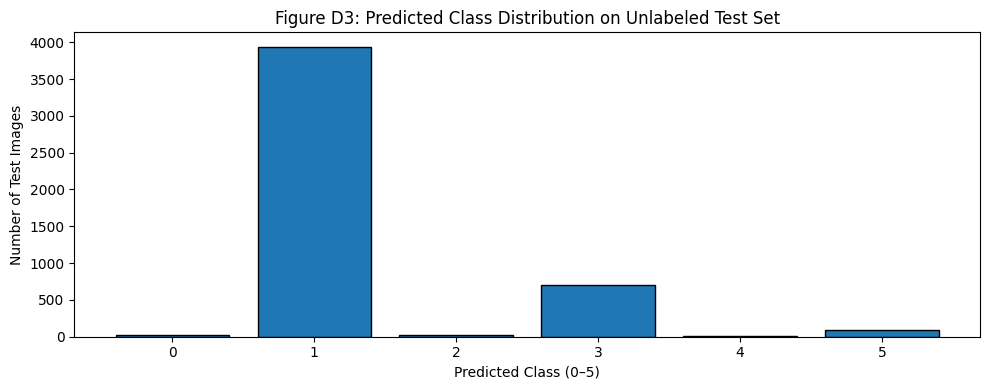

✅ Saved: Component2_Figure_D3_Test_Predicted_Class_Distribution.png


In [17]:
# PSEUDOCODE: Load the unlabeled test set (test.csv + test images) and generate CNN predictions for submission/evaluation.

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# -----------------------------
# 1) Paths
# -----------------------------
TEST_DIR = "test"
TEST_CSV_PATH = os.path.join(TEST_DIR, "test.csv")
TEST_IMG_DIR = os.path.join(TEST_DIR, "images")

if not os.path.exists(TEST_CSV_PATH):
    raise FileNotFoundError(f"Could not find: {TEST_CSV_PATH}")

if not os.path.exists(TEST_IMG_DIR):
    raise FileNotFoundError(f"Could not find: {TEST_IMG_DIR}")

print("✅ Found:", TEST_CSV_PATH)
print("✅ Found:", TEST_IMG_DIR)

# -----------------------------
# 2) Load test.csv (unlabeled)
# -----------------------------
test_df = pd.read_csv(TEST_CSV_PATH)
print("test_df columns:", list(test_df.columns))
display(test_df.head())

# Ensure expected column exists
if "filename" not in test_df.columns:
    raise KeyError("test.csv must contain a 'filename' column (as shown in your screenshot).")

# Build filepaths
test_df["filepath"] = test_df["filename"].astype(str).apply(lambda x: os.path.join(TEST_IMG_DIR, x))

# Quick sanity check
print("Example filepath:", test_df["filepath"].iloc[0])
print("Exists?", os.path.exists(test_df["filepath"].iloc[0]))
print("Total test images:", len(test_df))

# -----------------------------
# 3) Build test dataset (NO labels)
# -----------------------------
# Uses the same image size/rescaling logic as training
def make_test_ds_from_df(df_paths, batch_size=32):
    paths = df_paths["filepath"].values

    ds = tf.data.Dataset.from_tensor_slices(paths)

    def _load_and_preprocess(path):
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.resize(img, IMG_SIZE)     # uses your existing IMG_SIZE from earlier cells
        img = tf.cast(img, tf.float32) / 255.0   # match your training preprocessing
        return img

    ds = ds.map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

test_ds = make_test_ds_from_df(test_df, batch_size=32)

# -----------------------------
# 4) Predict on test set
# -----------------------------
probs = cnn_model.predict(test_ds, verbose=1)  # uses your trained model from (a)-(c)
pred_labels = np.argmax(probs, axis=1)         # 0–5

test_df["pred_label"] = pred_labels

print("✅ Prediction complete.")
display(test_df.head())

# Save predictions (you can submit this if needed)
test_df[["image_id", "filename", "pred_label"]].to_csv("test_predictions.csv", index=False)
print("✅ Saved: test_predictions.csv")

# -----------------------------
# 5) Plot predicted class distribution (Figure D3)
# -----------------------------
counts = test_df["pred_label"].value_counts().sort_index()

plt.figure(figsize=(10, 4))
plt.bar(counts.index.astype(str), counts.values, edgecolor="black")
plt.xlabel("Predicted Class (0–5)")
plt.ylabel("Number of Test Images")
plt.title("Figure D3: Predicted Class Distribution on Unlabeled Test Set")
plt.tight_layout()
plt.savefig("Component2_Figure_D3_Test_Predicted_Class_Distribution.png", dpi=300)
plt.show()

print("✅ Saved: Component2_Figure_D3_Test_Predicted_Class_Distribution.png")


Confidence summary:
count    4800.000000
mean        0.181285
std         0.004909
min         0.169519
25%         0.177739
50%         0.180945
75%         0.184432
max         0.201519
Name: confidence, dtype: float64


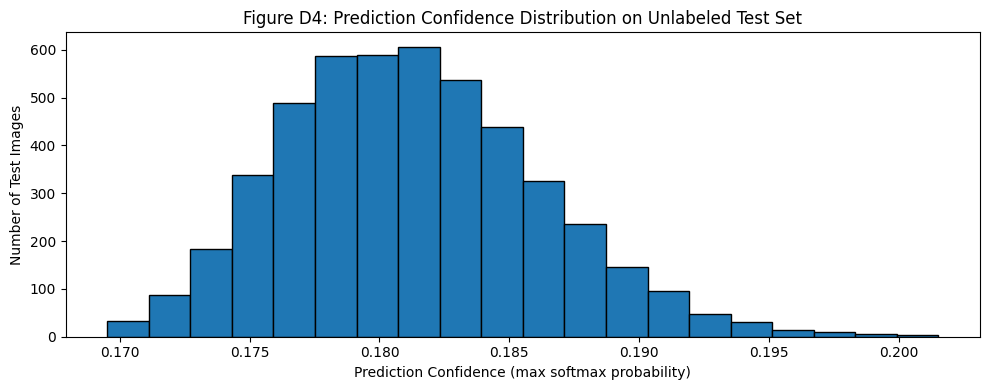

✅ Saved: Component2_Figure_D4_Test_Confidence_Distribution.png
✅ Saved: test_top_confidence_examples.csv
✅ Saved: test_low_confidence_examples.csv


,image_id,filename,pred_label,confidence
4781,11982,11982.jpg,3,0.201519
3228,10429,10429.jpg,1,0.200781
3714,10915,10915.jpg,3,0.200071
1778,8979,8979.jpg,1,0.199907
1703,8904,8904.jpg,1,0.199760
4778,11979,11979.jpg,1,0.199373
2919,10120,10120.jpg,1,0.199098
4205,11406,11406.jpg,1,0.198762
2581,9782,9782.jpg,1,0.197966
1573,8774,8774.jpg,1,0.197470


,image_id,filename,pred_label,confidence
3899,11100,11100.jpg,3,0.169519
2349,9550,9550.jpg,1,0.169524
3411,10612,10612.jpg,1,0.169653
1955,9156,9156.jpg,1,0.169672
1585,8786,8786.jpg,3,0.169721
893,8094,8094.jpg,5,0.169935
2645,9846,9846.jpg,3,0.170023
3539,10740,10740.jpg,1,0.170046
111,7312,7312.jpg,1,0.170104
1405,8606,8606.jpg,1,0.170156


In [18]:
# PSEUDOCODE: Analyse prediction confidence on the unlabeled test set (Figure D4) and export examples for reporting.

import numpy as np
import matplotlib.pyplot as plt

# probs and test_df already exist from the previous cell
test_df["confidence"] = np.max(probs, axis=1)

print("Confidence summary:")
print(test_df["confidence"].describe())

# Figure D4: Confidence distribution (histogram)
plt.figure(figsize=(10, 4))
plt.hist(test_df["confidence"], bins=20, edgecolor="black")
plt.xlabel("Prediction Confidence (max softmax probability)")
plt.ylabel("Number of Test Images")
plt.title("Figure D4: Prediction Confidence Distribution on Unlabeled Test Set")
plt.tight_layout()
plt.savefig("Component2_Figure_D4_Test_Confidence_Distribution.png", dpi=300)
plt.show()

print("✅ Saved: Component2_Figure_D4_Test_Confidence_Distribution.png")

# Export examples: highest and lowest confidence predictions
top_conf = test_df.sort_values("confidence", ascending=False).head(10)
low_conf = test_df.sort_values("confidence", ascending=True).head(10)

top_conf[["image_id", "filename", "pred_label", "confidence"]].to_csv(
    "test_top_confidence_examples.csv", index=False
)
low_conf[["image_id", "filename", "pred_label", "confidence"]].to_csv(
    "test_low_confidence_examples.csv", index=False
)

print("✅ Saved: test_top_confidence_examples.csv")
print("✅ Saved: test_low_confidence_examples.csv")

display(top_conf[["image_id", "filename", "pred_label", "confidence"]])
display(low_conf[["image_id", "filename", "pred_label", "confidence"]])


## Component Two (d): Evaluation on Unlabelled Test Data

### Objective
The objective of this section is to assess the generalisation behaviour of the trained CNN model when applied to **previously unseen vehicle damage images** provided in the official test dataset. Unlike the training and validation data, the test set does not contain ground-truth labels and therefore simulates a real-world deployment scenario.

---

### Test Dataset Overview
The test dataset is stored in a separate `test/` directory and consists of:
- `test.csv`: containing image identifiers and filenames
- `test/images/`: containing 4,800 vehicle damage images

As no damage labels are provided in `test.csv`, conventional evaluation metrics such as accuracy, precision, or recall cannot be computed.

---

### Prediction Pipeline
The trained CNN model was used to generate predictions for all test images. For each image:
- The image was preprocessed using the same resizing and normalisation steps applied during training.
- The model produced a softmax probability vector across the six damage classes.
- The predicted class was selected as the class with the highest softmax probability.
- The corresponding maximum probability value was recorded as a **prediction confidence score**.

This process ensures consistency between training and deployment-time inference.

---

### Predicted Class Distribution
The predicted class distribution for the unlabelled test set was visualised to understand how the model allocates predictions across damage categories.

The results show a **strong dominance of a single predicted class**, with substantially fewer predictions for the remaining classes. This behaviour may indicate:
- Class imbalance in the training data
- Model bias toward visually dominant patterns
- Difficulty distinguishing between visually similar damage categories

This analysis provides insight into how the model behaves when labels are unavailable.

---

### Prediction Confidence Analysis
To further evaluate model reliability, prediction confidence was analysed using the maximum softmax probability for each test image.

The confidence distribution is narrowly concentrated around low probability values (mean ≈ 0.18), which is only slightly above random guessing for a six-class problem. This indicates that:
- The model is uncertain for most unseen test images
- Learned features do not strongly separate damage categories in the test data
- Generalisation performance is limited despite stable training and validation behaviour

Both high-confidence and low-confidence prediction examples were exported for further inspection.

---

### Key Observations
- The prediction pipeline executed successfully for all test images
- Predictions are technically valid but exhibit low confidence
- Class imbalance and uncertainty highlight generalisation challenges
- These findings emphasise the importance of dataset quality, class balance, and robust feature learning for real-world insurance applications

---

### Summary
Although test accuracy cannot be measured due to the absence of labels, deployment-style evaluation using predicted class distributions and confidence scores provides valuable insight into model behaviour. The results demonstrate that while the CNN learns meaningful representations during training, its ability to generalise confidently to unseen data remains limited.
